In [1]:
# Install necessary libraries
!pip install pytorch-tabnet
!pip install captum
!pip install optuna
!pip install imbalanced-learn
!pip install dask-expr
!pip install scikit-learn-contrib
!pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.7 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.10.0
    Uninstalling dask-2024.10.0:
      Successfully uninstalled dask-2024.10.0
ERROR: Could not find a version that satisfies the requirement scikit-learn-contrib (from versions: none)
ERROR: No matching distribution found for scikit-learn-contrib


In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Handling imbalanced data
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks

# Deep Learning Model
from pytorch_tabnet.tab_model import TabNetClassifier

# Explainable AI
import shap

# Hyperparameter Optimization
import optuna
from optuna import Trial

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# For model saving and loading
import joblib

# Import torch for TabNet
import torch

# Additional imports for Permutation Regularization
import torch.nn as nn


In [4]:
# -------------------
# 3. Load and Preprocess the Dataset
# -------------------
# Load the dataset
data = pd.read_csv('/content/fetal_health.csv')  # Update the path as necessary

# Display the first five rows to verify
print("First five rows of the dataset:")
print(data.head())

# Check the shape of the dataset
print(f"\nDataset Shape: {data.shape}")

# Features to drop based on prior analysis
features_to_drop = [
    'fetal_movement',
    'histogram_width',
    'histogram_max',
    'mean_value_of_long_term_variability',
    'histogram_number_of_peaks',
    'light_decelerations',
    'histogram_tendency',
    'histogram_number_of_zeroes',
    'severe_decelerations',
    'baseline value',
    'histogram_min'
]

# Drop the specified features
data_dropped = data.drop(columns=features_to_drop)

# Verify the remaining features
print("\nFeatures after dropping less important ones:")
print(data_dropped.columns.tolist())

# Check the new shape of the dataset
print(f"\nNew Dataset Shape after dropping features: {data_dropped.shape}")

# Convert 'fetal_health' to integer
data_dropped['fetal_health'] = data_dropped['fetal_health'].astype(int)

# Mapping numerical classes to descriptive labels
health_mapping = {1: 'Normal', 2: 'Suspect', 3: 'Pathological'}
data_dropped['fetal_health_label'] = data_dropped['fetal_health'].map(health_mapping)

# Display the mapping
print("\nDataset with Mapped Labels:")
print(data_dropped[['fetal_health', 'fetal_health_label']].head())

# Features and target
X = data_dropped.drop(['fetal_health', 'fetal_health_label'], axis=1)
y = data_dropped['fetal_health']


First five rows of the dataset:
   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0 


Resampled X shape after ADASYN + Tomek Links: (4883, 10)
Resampled y distribution after ADASYN + Tomek Links:
fetal_health
3    1651
1    1642
2    1590
Name: count, dtype: int64


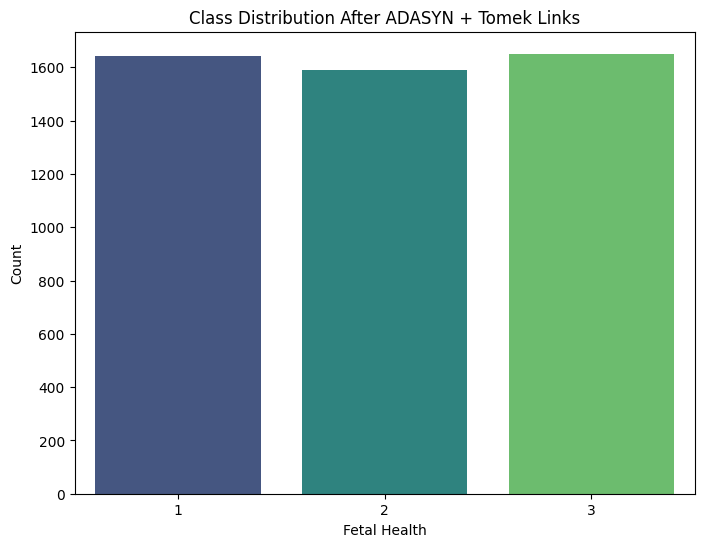

In [5]:
# Initialize ADASYN with 'auto' strategy to resample all classes
adasyn = ADASYN(sampling_strategy='auto', random_state=42)

# Apply ADASYN to the dataset
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

# Initialize Tomek Links
tomek = TomekLinks()

# Apply Tomek Links to clean the dataset
X_resampled, y_resampled = tomek.fit_resample(X_adasyn, y_adasyn)

# Display the shape of the resampled dataset and class distribution
print(f"\nResampled X shape after ADASYN + Tomek Links: {X_resampled.shape}")
print(f"Resampled y distribution after ADASYN + Tomek Links:\n{y_resampled.value_counts()}")

# Visualize the resampled class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled, palette='viridis')
plt.title('Class Distribution After ADASYN + Tomek Links')
plt.xlabel('Fetal Health')
plt.ylabel('Count')
plt.show()


In [6]:
# Split the resampled data (70% train, 30% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Display the shapes of the training and testing sets
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Verify scaling by checking min and max values
print("\nMin of Scaled Training Features (Should be 0):")
print(X_train_scaled.min())

print("\nMax of Scaled Training Features (Should be 1):")
print(X_train_scaled.max())

# Adjust the target values so they start from 0
y_train = y_train - 1
y_test = y_test - 1

# Display the adjusted target distributions
print("\nAdjusted y_train distribution:")
print(pd.Series(y_train).value_counts())

print("\nAdjusted y_test distribution:")
print(pd.Series(y_test).value_counts())

# Further split the training data into training and validation sets (80% train, 20% validation)
X_train_final, X_valid, y_train_final, y_valid = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Display the shapes of the final training and validation sets
print(f"\nFinal Training set shape: {X_train_final.shape}")
print(f"Validation set shape: {X_valid.shape}")



Training set shape: (3418, 10)
Testing set shape: (1465, 10)

Min of Scaled Training Features (Should be 0):
accelerations                                             0.0
uterine_contractions                                      0.0
prolongued_decelerations                                  0.0
abnormal_short_term_variability                           0.0
mean_value_of_short_term_variability                      0.0
percentage_of_time_with_abnormal_long_term_variability    0.0
histogram_mode                                            0.0
histogram_mean                                            0.0
histogram_median                                          0.0
histogram_variance                                        0.0
dtype: float64

Max of Scaled Training Features (Should be 1):
accelerations                                             1.0
uterine_contractions                                      1.0
prolongued_decelerations                                  1.0
abnormal_short_term_v

In [7]:
# Define the objective function for Optuna
def objective(trial: Trial):
    # Define the hyperparameter space
    n_d = trial.suggest_int('n_d', 32, 128)
    n_a = trial.suggest_int('n_a', 32, 128)
    n_steps = trial.suggest_int('n_steps', 3, 10)
    gamma = trial.suggest_float('gamma', 1.0, 2.0)
    lambda_sparse = trial.suggest_float('lambda_sparse', 1e-4, 1e-2, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])

    # Initialize TabNet with current hyperparameters
    tabnet = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=learning_rate),
        mask_type='sparsemax',
        verbose=0
    )

    # Train the model on the final training set
    tabnet.fit(
        X_train=X_train_final.values,
        y_train=y_train_final.values,
        eval_set=[(X_valid.values, y_valid.values)],
        eval_name=['valid'],
        eval_metric=['accuracy'],
        max_epochs=100,
        patience=20,
        batch_size=batch_size,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    # Predict on the validation set
    y_pred = tabnet.predict(X_valid.values)
    accuracy = accuracy_score(y_valid, y_pred)

    return accuracy

# Create and optimize the Optuna study
study = optuna.create_study(direction='maximize', study_name='TabNet Hyperparameter Optimization')
study.optimize(objective, n_trials=50, timeout=3600)  # Adjust n_trials and timeout as needed

# Display the best hyperparameters and validation accuracy
print("Best Hyperparameters: ", study.best_params)
print("Best Validation Accuracy: ", study.best_value)


[I 2025-01-15 03:56:10,859] A new study created in memory with name: TabNet Hyperparameter Optimization



Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.93421


[I 2025-01-15 04:01:02,986] Trial 0 finished with value: 0.9342105263157895 and parameters: {'n_d': 126, 'n_a': 64, 'n_steps': 10, 'gamma': 1.1942005788783747, 'lambda_sparse': 0.00024630707577207907, 'learning_rate': 0.09166578703475932, 'batch_size': 256}. Best is trial 0 with value: 0.9342105263157895.



Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.93421


[I 2025-01-15 04:02:43,657] Trial 1 finished with value: 0.9342105263157895 and parameters: {'n_d': 117, 'n_a': 111, 'n_steps': 3, 'gamma': 1.718392708589683, 'lambda_sparse': 0.003924734947764451, 'learning_rate': 0.04215206750923912, 'batch_size': 128}. Best is trial 0 with value: 0.9342105263157895.


Stop training because you reached max_epochs = 100 with best_epoch = 89 and best_valid_accuracy = 0.95468


[I 2025-01-15 04:04:29,530] Trial 2 finished with value: 0.9546783625730995 and parameters: {'n_d': 64, 'n_a': 66, 'n_steps': 6, 'gamma': 1.206953628263216, 'lambda_sparse': 0.002322501737670916, 'learning_rate': 0.0066201561443909665, 'batch_size': 512}. Best is trial 2 with value: 0.9546783625730995.



Early stopping occurred at epoch 31 with best_epoch = 11 and best_valid_accuracy = 0.63596


[I 2025-01-15 04:05:17,793] Trial 3 finished with value: 0.6359649122807017 and parameters: {'n_d': 101, 'n_a': 54, 'n_steps': 7, 'gamma': 1.9620736302225241, 'lambda_sparse': 0.000418431921127061, 'learning_rate': 0.021068029500249944, 'batch_size': 512}. Best is trial 2 with value: 0.9546783625730995.


Stop training because you reached max_epochs = 100 with best_epoch = 93 and best_valid_accuracy = 0.9269


[I 2025-01-15 04:07:37,410] Trial 4 finished with value: 0.9269005847953217 and parameters: {'n_d': 65, 'n_a': 53, 'n_steps': 9, 'gamma': 1.4306504728567102, 'lambda_sparse': 0.0006625409048871943, 'learning_rate': 0.0015597916999642012, 'batch_size': 512}. Best is trial 2 with value: 0.9546783625730995.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_accuracy = 0.9386


[I 2025-01-15 04:09:10,149] Trial 5 finished with value: 0.9385964912280702 and parameters: {'n_d': 109, 'n_a': 45, 'n_steps': 4, 'gamma': 1.644550980441934, 'lambda_sparse': 0.00962313129270921, 'learning_rate': 0.049665729250530345, 'batch_size': 512}. Best is trial 2 with value: 0.9546783625730995.



Early stopping occurred at epoch 90 with best_epoch = 70 and best_valid_accuracy = 0.95614


[I 2025-01-15 04:12:11,068] Trial 6 finished with value: 0.956140350877193 and parameters: {'n_d': 116, 'n_a': 122, 'n_steps': 5, 'gamma': 1.7341743428462393, 'lambda_sparse': 0.0008437941243678673, 'learning_rate': 0.0033526022410583687, 'batch_size': 256}. Best is trial 6 with value: 0.956140350877193.



Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.93421


[I 2025-01-15 04:14:37,499] Trial 7 finished with value: 0.9342105263157895 and parameters: {'n_d': 77, 'n_a': 115, 'n_steps': 9, 'gamma': 1.148297458192623, 'lambda_sparse': 0.007730422513541707, 'learning_rate': 0.0404421843586171, 'batch_size': 256}. Best is trial 6 with value: 0.956140350877193.



Early stopping occurred at epoch 97 with best_epoch = 77 and best_valid_accuracy = 0.95322


[I 2025-01-15 04:18:15,538] Trial 8 finished with value: 0.9532163742690059 and parameters: {'n_d': 119, 'n_a': 88, 'n_steps': 5, 'gamma': 1.1968720523087288, 'lambda_sparse': 0.002754446349542278, 'learning_rate': 0.050802802302736684, 'batch_size': 128}. Best is trial 6 with value: 0.956140350877193.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_accuracy = 0.95906


[I 2025-01-15 04:19:22,128] Trial 9 finished with value: 0.9590643274853801 and parameters: {'n_d': 53, 'n_a': 50, 'n_steps': 4, 'gamma': 1.8872815385588537, 'lambda_sparse': 0.006548099406103877, 'learning_rate': 0.004611069603407387, 'batch_size': 512}. Best is trial 9 with value: 0.9590643274853801.


Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_valid_accuracy = 0.95614


[I 2025-01-15 04:20:01,883] Trial 10 finished with value: 0.956140350877193 and parameters: {'n_d': 33, 'n_a': 32, 'n_steps': 3, 'gamma': 1.9801546559584757, 'lambda_sparse': 0.00010259458526056779, 'learning_rate': 0.010066797681329821, 'batch_size': 512}. Best is trial 9 with value: 0.9590643274853801.



Early stopping occurred at epoch 88 with best_epoch = 68 and best_valid_accuracy = 0.95468


[I 2025-01-15 04:21:36,870] Trial 11 finished with value: 0.9546783625730995 and parameters: {'n_d': 38, 'n_a': 92, 'n_steps': 5, 'gamma': 1.7813215919988865, 'lambda_sparse': 0.0012857532814929762, 'learning_rate': 0.0023198299307965447, 'batch_size': 256}. Best is trial 9 with value: 0.9590643274853801.



Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.95029


[I 2025-01-15 04:24:25,374] Trial 12 finished with value: 0.9502923976608187 and parameters: {'n_d': 93, 'n_a': 103, 'n_steps': 7, 'gamma': 1.5601799706627095, 'lambda_sparse': 0.0012571814234346023, 'learning_rate': 0.003702271324257522, 'batch_size': 256}. Best is trial 9 with value: 0.9590643274853801.



Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.95468


[I 2025-01-15 04:26:12,217] Trial 13 finished with value: 0.9546783625730995 and parameters: {'n_d': 52, 'n_a': 125, 'n_steps': 5, 'gamma': 1.8496194705410565, 'lambda_sparse': 0.000729117710377311, 'learning_rate': 0.005809794082095498, 'batch_size': 256}. Best is trial 9 with value: 0.9590643274853801.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.95614


[I 2025-01-15 04:27:39,712] Trial 14 finished with value: 0.956140350877193 and parameters: {'n_d': 88, 'n_a': 78, 'n_steps': 4, 'gamma': 1.4522598654099896, 'lambda_sparse': 0.004588434297985324, 'learning_rate': 0.001000368845027794, 'batch_size': 128}. Best is trial 9 with value: 0.9590643274853801.


Stop training because you reached max_epochs = 100 with best_epoch = 93 and best_valid_accuracy = 0.94737


[I 2025-01-15 04:30:03,066] Trial 15 finished with value: 0.9473684210526315 and parameters: {'n_d': 49, 'n_a': 127, 'n_steps': 6, 'gamma': 1.8505329010164533, 'lambda_sparse': 0.0002597025134609313, 'learning_rate': 0.01145747867745519, 'batch_size': 512}. Best is trial 9 with value: 0.9590643274853801.



Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.96491


[I 2025-01-15 04:31:02,069] Trial 16 finished with value: 0.9649122807017544 and parameters: {'n_d': 77, 'n_a': 35, 'n_steps': 4, 'gamma': 1.00466576920397, 'lambda_sparse': 0.0018173927015242204, 'learning_rate': 0.0028074922974144732, 'batch_size': 256}. Best is trial 16 with value: 0.9649122807017544.



Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_accuracy = 0.96345


[I 2025-01-15 04:32:07,664] Trial 17 finished with value: 0.9634502923976608 and parameters: {'n_d': 74, 'n_a': 34, 'n_steps': 4, 'gamma': 1.0153240893434847, 'lambda_sparse': 0.005606747608329041, 'learning_rate': 0.0023718524489853847, 'batch_size': 256}. Best is trial 16 with value: 0.9649122807017544.


Stop training because you reached max_epochs = 100 with best_epoch = 89 and best_valid_accuracy = 0.97076


[I 2025-01-15 04:33:16,515] Trial 18 finished with value: 0.9707602339181286 and parameters: {'n_d': 79, 'n_a': 34, 'n_steps': 3, 'gamma': 1.0067726389808187, 'lambda_sparse': 0.0019657751342309153, 'learning_rate': 0.0020203227768361034, 'batch_size': 256}. Best is trial 18 with value: 0.9707602339181286.



Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.96491


[I 2025-01-15 04:34:15,981] Trial 19 finished with value: 0.9649122807017544 and parameters: {'n_d': 86, 'n_a': 39, 'n_steps': 3, 'gamma': 1.006387917470765, 'lambda_sparse': 0.001909391514515438, 'learning_rate': 0.0011285025846508303, 'batch_size': 256}. Best is trial 18 with value: 0.9707602339181286.


Stop training because you reached max_epochs = 100 with best_epoch = 82 and best_valid_accuracy = 0.96053


[I 2025-01-15 04:35:31,017] Trial 20 finished with value: 0.9605263157894737 and parameters: {'n_d': 64, 'n_a': 68, 'n_steps': 3, 'gamma': 1.3062753137131002, 'lambda_sparse': 0.001597815005922769, 'learning_rate': 0.002097798837448509, 'batch_size': 256}. Best is trial 18 with value: 0.9707602339181286.



Early stopping occurred at epoch 90 with best_epoch = 70 and best_valid_accuracy = 0.97222


[I 2025-01-15 04:36:35,960] Trial 21 finished with value: 0.9722222222222222 and parameters: {'n_d': 87, 'n_a': 41, 'n_steps': 3, 'gamma': 1.0069592979950976, 'lambda_sparse': 0.0022982046950226574, 'learning_rate': 0.001033381065032292, 'batch_size': 256}. Best is trial 21 with value: 0.9722222222222222.



Early stopping occurred at epoch 88 with best_epoch = 68 and best_valid_accuracy = 0.97222


[I 2025-01-15 04:37:46,781] Trial 22 finished with value: 0.9722222222222222 and parameters: {'n_d': 95, 'n_a': 42, 'n_steps': 3, 'gamma': 1.0975400788189926, 'lambda_sparse': 0.0031566203541543284, 'learning_rate': 0.0014489544528466318, 'batch_size': 256}. Best is trial 21 with value: 0.9722222222222222.



Early stopping occurred at epoch 94 with best_epoch = 74 and best_valid_accuracy = 0.96637


[I 2025-01-15 04:39:04,861] Trial 23 finished with value: 0.966374269005848 and parameters: {'n_d': 99, 'n_a': 44, 'n_steps': 3, 'gamma': 1.1025965201577153, 'lambda_sparse': 0.0030126489283829813, 'learning_rate': 0.0014245188491291577, 'batch_size': 256}. Best is trial 21 with value: 0.9722222222222222.



Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.96637


[I 2025-01-15 04:40:18,760] Trial 24 finished with value: 0.966374269005848 and parameters: {'n_d': 102, 'n_a': 58, 'n_steps': 3, 'gamma': 1.3118492413104714, 'lambda_sparse': 0.0036726547700997865, 'learning_rate': 0.0017503585502271846, 'batch_size': 256}. Best is trial 21 with value: 0.9722222222222222.


Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_valid_accuracy = 0.9693


[I 2025-01-15 04:42:15,915] Trial 25 finished with value: 0.9692982456140351 and parameters: {'n_d': 84, 'n_a': 75, 'n_steps': 4, 'gamma': 1.0837623698409786, 'lambda_sparse': 0.0011047681138075004, 'learning_rate': 0.0013336408563283527, 'batch_size': 256}. Best is trial 21 with value: 0.9722222222222222.


Stop training because you reached max_epochs = 100 with best_epoch = 93 and best_valid_accuracy = 0.96345


[I 2025-01-15 04:46:13,742] Trial 26 finished with value: 0.9634502923976608 and parameters: {'n_d': 92, 'n_a': 43, 'n_steps': 8, 'gamma': 1.3113086386494341, 'lambda_sparse': 0.0023874308290393583, 'learning_rate': 0.0010465956499368025, 'batch_size': 128}. Best is trial 21 with value: 0.9722222222222222.



Early stopping occurred at epoch 95 with best_epoch = 75 and best_valid_accuracy = 0.96784


[I 2025-01-15 04:47:46,476] Trial 27 finished with value: 0.9678362573099415 and parameters: {'n_d': 106, 'n_a': 59, 'n_steps': 3, 'gamma': 1.0896551314260412, 'lambda_sparse': 0.004920730127852639, 'learning_rate': 0.015849991823474595, 'batch_size': 256}. Best is trial 21 with value: 0.9722222222222222.



Early stopping occurred at epoch 97 with best_epoch = 77 and best_valid_accuracy = 0.95614


[I 2025-01-15 04:49:42,763] Trial 28 finished with value: 0.956140350877193 and parameters: {'n_d': 68, 'n_a': 47, 'n_steps': 6, 'gamma': 1.235001798886127, 'lambda_sparse': 0.0017326211079634936, 'learning_rate': 0.001609185278615665, 'batch_size': 256}. Best is trial 21 with value: 0.9722222222222222.


Stop training because you reached max_epochs = 100 with best_epoch = 80 and best_valid_accuracy = 0.96199


[I 2025-01-15 04:53:50,762] Trial 29 finished with value: 0.9619883040935673 and parameters: {'n_d': 128, 'n_a': 38, 'n_steps': 10, 'gamma': 1.1236249460205898, 'lambda_sparse': 0.0005632954062292413, 'learning_rate': 0.0065471683021451794, 'batch_size': 256}. Best is trial 21 with value: 0.9722222222222222.



Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.96637


[I 2025-01-15 04:55:38,543] Trial 30 finished with value: 0.966374269005848 and parameters: {'n_d': 94, 'n_a': 60, 'n_steps': 5, 'gamma': 1.371305650284323, 'lambda_sparse': 0.0036699399923588354, 'learning_rate': 0.0032662171813168978, 'batch_size': 256}. Best is trial 21 with value: 0.9722222222222222.



Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.9693


[I 2025-01-15 04:56:59,884] Trial 31 finished with value: 0.9692982456140351 and parameters: {'n_d': 84, 'n_a': 76, 'n_steps': 4, 'gamma': 1.070734260359248, 'lambda_sparse': 0.0010629523971020234, 'learning_rate': 0.001399991679613068, 'batch_size': 256}. Best is trial 21 with value: 0.9722222222222222.


Best Hyperparameters:  {'n_d': 87, 'n_a': 41, 'n_steps': 3, 'gamma': 1.0069592979950976, 'lambda_sparse': 0.0022982046950226574, 'learning_rate': 0.001033381065032292, 'batch_size': 256}
Best Validation Accuracy:  0.9722222222222222


In [11]:
# -------------------
# Part 1: Data Augmentation Function
# -------------------

def augment_data(X, y, permutation_prob=0.1):
    """
    Augment the dataset by randomly permuting feature orders with a given probability.

    Parameters:
    - X (numpy.ndarray or pandas.DataFrame): Feature matrix.
    - y (numpy.ndarray or pandas.Series): Target vector.
    - permutation_prob (float): Probability of permuting each sample.

    Returns:
    - X_augmented (numpy.ndarray): Augmented feature matrix.
    - y_augmented (numpy.ndarray): Augmented target vector.
    """
    X_augmented = []
    y_augmented = []
    for sample, label in zip(X, y):
        if np.random.rand() < permutation_prob:
            perm = np.random.permutation(sample.shape[0])
            sample = sample[perm]
        X_augmented.append(sample)
        y_augmented.append(label)
    return np.array(X_augmented), np.array(y_augmented)


In [12]:
# -------------------
# Part 2: Apply Data Augmentation
# -------------------

# Set the permutation probability (e.g., 10% of the training samples will have permuted features)
permutation_probability = 0.1

# Apply the augmentation function to the final training set
X_train_augmented, y_train_augmented = augment_data(
    X_train_final.values,
    y_train_final.values,
    permutation_prob=permutation_probability
)

# Display the shape of the augmented dataset
print(f"Original Training Set Shape: {X_train_final.shape}")
print(f"Augmented Training Set Shape: {X_train_augmented.shape}")


Original Training Set Shape: (2734, 10)
Augmented Training Set Shape: (2734, 10)


In [13]:
# -------------------
# Part 3: Initialize and Train TabNet with Augmented Data
# -------------------

# Initialize the TabNetClassifier with the best hyperparameters from Optuna
perm_reg_tabnet = TabNetClassifier(
    input_dim=X_train_final.shape[1],    # Number of features
    output_dim=3,                        # Number of classes: Normal, Suspect, Pathological
    n_d=study.best_params['n_d'],
    n_a=study.best_params['n_a'],
    n_steps=study.best_params['n_steps'],
    gamma=study.best_params['gamma'],
    lambda_sparse=study.best_params['lambda_sparse'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': study.best_params['learning_rate']},
    mask_type='sparsemax',
    verbose=1,
    seed=42  # For reproducibility
)

# Train the model on the augmented training data
perm_reg_tabnet.fit(
    X_train=X_train_augmented,
    y_train=y_train_augmented,
    eval_set=[(X_valid.values, y_valid.values), (X_test_scaled.values, y_test.values)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=study.best_params['batch_size'],
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


epoch 0  | loss: 1.7639  | train_accuracy: 0.25146 | valid_accuracy: 0.21775 |  0:00:02s
epoch 1  | loss: 1.03473 | train_accuracy: 0.34942 | valid_accuracy: 0.34061 |  0:00:03s
epoch 2  | loss: 0.81778 | train_accuracy: 0.36988 | valid_accuracy: 0.35427 |  0:00:04s
epoch 3  | loss: 0.68172 | train_accuracy: 0.42982 | valid_accuracy: 0.41638 |  0:00:05s
epoch 4  | loss: 0.64531 | train_accuracy: 0.46199 | valid_accuracy: 0.44232 |  0:00:06s
epoch 5  | loss: 0.57001 | train_accuracy: 0.50731 | valid_accuracy: 0.48942 |  0:00:07s
epoch 6  | loss: 0.53705 | train_accuracy: 0.53363 | valid_accuracy: 0.51058 |  0:00:08s
epoch 7  | loss: 0.5281  | train_accuracy: 0.53509 | valid_accuracy: 0.51468 |  0:00:09s
epoch 8  | loss: 0.51796 | train_accuracy: 0.55263 | valid_accuracy: 0.52628 |  0:00:10s
epoch 9  | loss: 0.50432 | train_accuracy: 0.54532 | valid_accuracy: 0.52491 |  0:00:11s
epoch 10 | loss: 0.47616 | train_accuracy: 0.55994 | valid_accuracy: 0.53857 |  0:00:12s
epoch 11 | loss: 0.50


Permutation Regularized TabNet Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.91      0.95       493
     Suspect       0.91      0.96      0.94       477
Pathological       0.98      0.99      0.98       495

    accuracy                           0.96      1465
   macro avg       0.96      0.96      0.96      1465
weighted avg       0.96      0.96      0.96      1465



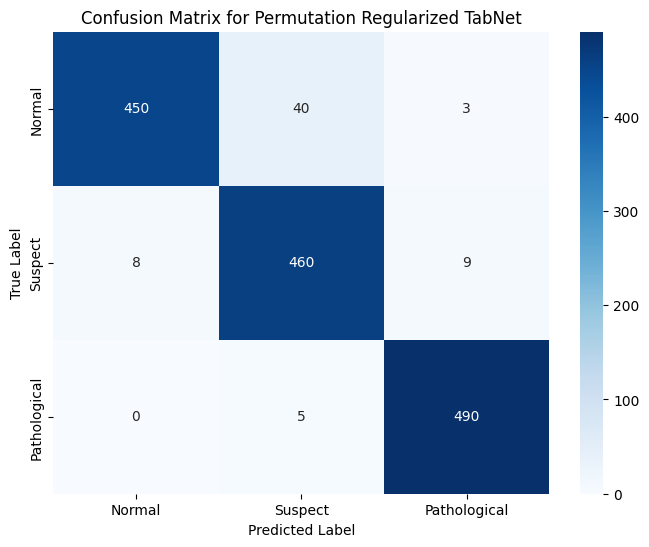

In [14]:
# -------------------
# Part 4: Predict and Evaluate on the Test Set
# -------------------

# Predict on the test set
y_pred_perm_reg = perm_reg_tabnet.predict(X_test_scaled.values)

# Generate the Classification Report
print("\nPermutation Regularized TabNet Classification Report:")
print(classification_report(y_test, y_pred_perm_reg, target_names=['Normal', 'Suspect', 'Pathological']))

# Generate the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_perm_reg)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('Confusion Matrix for Permutation Regularized TabNet')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



Permutation Feature Importance:


,Feature,Importance
5,percentage_of_time_with_abnormal_long_term_var...,0.238635
3,abnormal_short_term_variability,0.216519
7,histogram_mean,0.193174
0,accelerations,0.119044
1,uterine_contractions,0.117816
6,histogram_mode,0.111672
8,histogram_median,0.109625
2,prolongued_decelerations,0.107986
4,mean_value_of_short_term_variability,0.082867
9,histogram_variance,0.078225


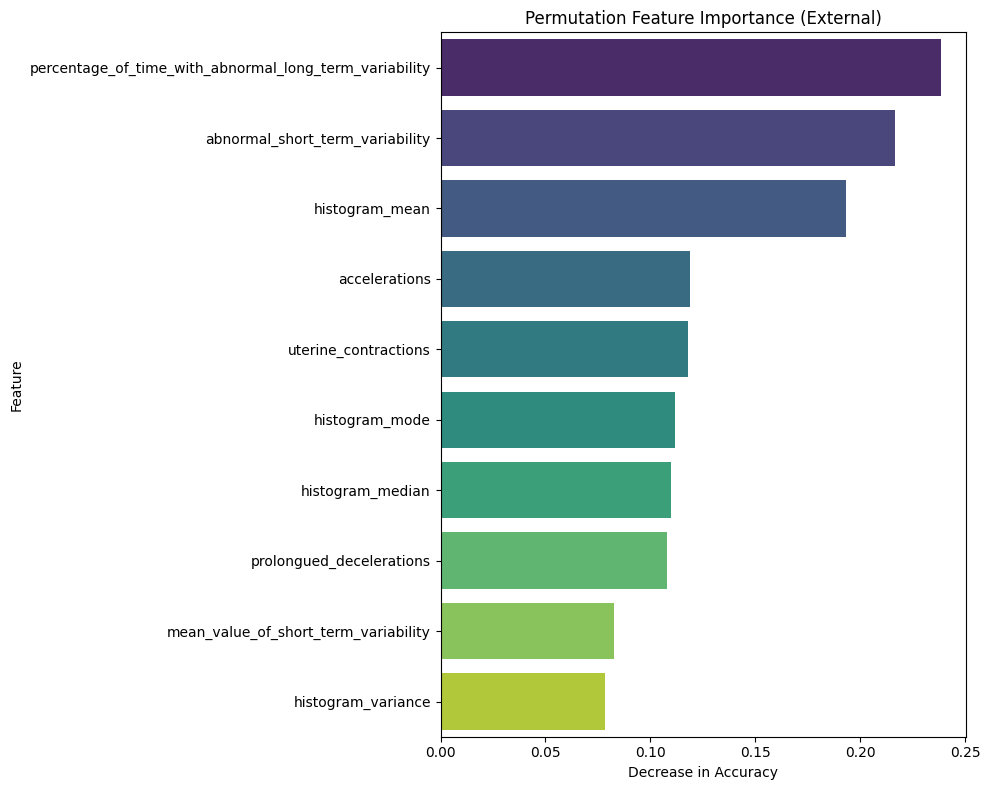

In [17]:
# -------------------
# Part 5: Compute Permutation Feature Importance
# -------------------

def permutation_feature_importance(model, X, y, metric=accuracy_score, n_repeats=5):
    """
    Compute permutation feature importance for a trained model.

    Parameters:
    - model (TabNetClassifier): Trained TabNet model.
    - X (pandas.DataFrame): Feature matrix.
    - y (numpy.ndarray or pandas.Series): True labels.
    - metric (function): Performance metric to evaluate (default: accuracy_score).
    - n_repeats (int): Number of times to permute a feature.

    Returns:
    - feature_importances (dict): Mapping of feature names to importance scores.
    """
    feature_importances = {}
    baseline = metric(y, model.predict(X.values))

    for col in X.columns:
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            X_permuted[col] = np.random.permutation(X_permuted[col].values)
            y_pred = model.predict(X_permuted.values)
            score = metric(y, y_pred)
            scores.append(score)
        # Importance is the drop in performance
        importance = baseline - np.mean(scores)
        feature_importances[col] = importance

    return feature_importances

# Compute permutation feature importance
feature_importances = permutation_feature_importance(
    model=perm_reg_tabnet,
    X=X_test_scaled,
    y=y_test,
    metric=accuracy_score,
    n_repeats=5
)

# Convert to DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': list(feature_importances.keys()),
    'Importance': list(feature_importances.values())
}).sort_values(by='Importance', ascending=False)

# Display feature importances
print("\nPermutation Feature Importance:")
display(importance_df)

# Plotting Feature Importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Permutation Feature Importance (External)')
plt.xlabel('Decrease in Accuracy')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
